<a href="https://colab.research.google.com/github/torbenbillow/CBS-AML-PROJECT/blob/main/notebooks/01_price_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The intention of the following machine learning model is to provide Airbnb hosts with a real-time, automated pricing suggestion tool, based on a property's entered attributes (e.g., location, number of beds, amenities). The model will run as the last step of creating a new listing, after all details except price have been entered. Once the model outputs a price suggestion, the host can override it if she chooses.

The source data is a point-in-time scrape of Airbnb listings in Copenhagen from June 2025. Our core assumption is that a given property's listed price, after filtering for active listings (see "FILTER LISTINGS FOR MORE INFORMATIVE DATA" section below), generally reflects a reasonable market value given the property's characteristics. We recognize that this is not always the case, and the model will thereby learn from listings with potentially inflated prices (relative to their peers) or low occupancy.

In an ideal scenario, a more robust training target would be based on historical, "successful" listings; that is, those with a high, sustained occupancy rate. Access to historical booking and occupancy data would provide a more trustworthy baseline for predicting optimal (profitable) prices, rather than just current listed prices.

# IMPORT LIBRARIES FOR DATA PROCESSING AND CLEANSING

In [2]:
import pandas as pd
import numpy as np

from google.colab import drive
pd.options.mode.copy_on_write = True   # Make sure that when copies are made, the original object isn't subsequently updated

# LOAD DATA FROM GOOGLE DRIVE *[CHANGE TO LOCAL FILE BEFORE HAND-IN]*

The raw Airbnb data on Copenhagen was sourced from the following website: https://insideairbnb.com/get-the-data/. It is a scrape from June, 2025.

In [3]:
print("Loading raw data from Google Drive location...\n")
file_id = "1Iyr7zX8u0gKWKUWCSgZUpcvbTuYBmw1V"             # File id from Google Drive
url = f"https://drive.google.com/uc?id={file_id}"         # URL to Google Sheet with the inputted file_id
listings_raw = pd.read_csv(url)                           # Store the data in the "listings_raw" variable

print("Raw data successfully loaded.\n")
print("Raw dataframe shape:",listings_raw.shape)          # Print the shape of the dataframe so we have a baseline

Loading raw data from Google Drive location...

Raw data successfully loaded.

Raw dataframe shape: (22684, 79)


# DATA CLEANSING

The below data cleansing process proved to be highly iterative and dependent on intermediate results. Initial decisions to drop or impute certain attributes often created overlaps, or rendered subsequent activities unnecessary due to the high correlation of missing or "bad" data. Several cleansing activities (such as the choice to filter out inactive listings) were reworked after examining the training cross-validation results of the baseline models, creating a feedback loop between feature engineering and model performance.

To ensure the integrity of the model and prevent data leakage, no inter-row imputations were performed. Prior to establishing the Scikit-learn pipeline and column transformer, only intra-row imputations were calculated (see "CLEAN UP "bedroom" AND "bed" ATTRIBUTES" section below), such that statistics would not be derived including the test set. Scaling and onehot encoding are encapsulated in the pipeline for consistency, reproducibility, and to ensure that statistics like standard deviation and mean are being calculated only on the training data.  

The biggest challenge with deploying this model in production (that is, as a feature of the Airbnb application, being fed by the live stream of host-entered data) would be to format and cleanse the real-time data. It would be crucial to ensure that the data cleansing steps and model pipelines were build to handle unexpected values. However, this is mitigated by the following:

1.   Mandatory Fields: Required fields should be marked as such to prevent missing data.
2.   Data Integrity Requirements: Data types should be enforced to prevent unexpected values.
3.   The OneHotEncoder in the pipeline must be configured with handle_unknown='ignore' to process new categorical values like room or property types.

## DISPLAY ALL RAW DATA COLUMNS AND MANUALLY REMOVE UNWANTED COLUMNS

In the code blocks below, we inspect the various columns present in the original data set and elect to drop a number of them. We have, for example, made the determination that a number of columns are irrelevant for price prediction (domain knowledge), others are completely empty and thus provide no value, and a handfull display elements of multicollinearity and are thereby removed. All reasons are noted as comments in the code.

In [4]:
# Copy the original dataframe to the df variable, so the original data set can be used for comparisons
df = listings_raw.copy()

# List all columns
pd.set_option('display.max_rows', None)
display(pd.DataFrame({"column_name": df.columns}))

column_name
0                                             id
1                                    listing_url
2                                      scrape_id
3                                   last_scraped
4                                         source
5                                           name
6                                    description
7                          neighborhood_overview
8                                    picture_url
9                                        host_id
10                                      host_url
11                                     host_name
12                                    host_since
13                                 host_location
14                                    host_about
15                            host_response_time
16                            host_response_rate
17                          host_acceptance_rate
18                             host_is_superhost
19                            host_thumbnail_url
20                              host_picture_url
21                            host_neighbourhood
22                           host_listings_count
23                     host_total_listings_count
24                            host_verifications
25                          host_has_profile_pic
26                        host_identity_verified
27                                 neighbourhood
28                        neighbourhood_cleansed
29                  neighbourhood_group_cleansed
30                                      latitude
31                                     longitude
32                                 property_type
33                                     room_type
34                                  accommodates
35                                     bathrooms
36                                bathrooms_text
37                                      bedrooms
38                                          beds
39                                     amenities
40                                         price
41                                minimum_nights
42                                maximum_nights
43                        minimum_minimum_nights
44                        maximum_minimum_nights
45                        minimum_maximum_nights
46                        maximum_maximum_nights
47                        minimum_nights_avg_ntm
48                        maximum_nights_avg_ntm
49                              calendar_updated
50                              has_availability
51                               availability_30
52                               availability_60
53                               availability_90
54                              availability_365
55                         calendar_last_scraped
56                             number_of_reviews
57                         number_of_reviews_ltm
58                        number_of_reviews_l30d
59                              availability_eoy
60                          number_of_reviews_ly
61                     estimated_occupancy_l365d
62                       estimated_revenue_l365d
63                                  first_review
64                                   last_review
65                          review_scores_rating
66                        review_scores_accuracy
67                     review_scores_cleanliness
68                         review_scores_checkin
69                   review_scores_communication
70                        review_scores_location
71                           review_scores_value
72                                       license
73                              instant_bookable
74                calculated_host_listings_count
75   calculated_host_listings_count_entire_homes
76  calculated_host_listings_count_private_rooms
77   calculated_host_listings_count_shared_rooms
78                             reviews_per_month

In [5]:
# The following columns are irrelevant, and thus, we have chosen to drop them.
df = df.drop(columns=["listing_url","scrape_id","source","host_id","host_url",
                      "calendar_last_scraped","first_review","host_neighbourhood"])

# The following columns could impact a listing's "success" (guests may discriminate based on
# a name or picture, for example), but due to the complexity of including them, and the scope
# of this project, we have chosen to drop them.

# However, we recognize that dropping the column does NOT prevent the model from learning the
# underlying bias through proxy features (indirect discrimination). If there truly is discrimination,
# it is already baked into the observed booking and pricing patterns in our training data.
df = df.drop(columns=["name","picture_url","host_name","host_thumbnail_url","host_picture_url"])

# Dropping the following columns in favor of "calculated_host_listings_count," because that is
# the direct calculation of how many listings a host has at the time of scrape. The metadata
# also notes that the following calculations are "unknown," and thereby less trustworthy.
df = df.drop(columns=["host_listings_count","host_total_listings_count"])

# Dropping in favor of "host_identitity_verified," which is a boolean that indicates whether
# or not the host is verified.
df = df.drop(columns=["host_verifications"])

# Dropping in favor of "neighborhood_cleansed."
df = df.drop(columns=["neighbourhood"])

# Dropping the following, as they are completely empty attributes.
df = df.drop(columns=["neighbourhood_group_cleansed","calendar_updated","license"])

# Dropping the following columns in favor of "mini_nights" and "maximum_nights."
df = df.drop(columns=["minimum_minimum_nights","maximum_minimum_nights","minimum_maximum_nights",
                      "maximum_maximum_nights","minimum_nights_avg_ntm","maximum_nights_avg_ntm"])

# Dropping the following columns, because there is no information about they represent.
df = df.drop(columns=["has_availability","availability_eoy"])

# Dropping the following columns in favor "number_of_reviews" for simplicity.
df = df.drop(columns=["number_of_reviews_ltm","number_of_reviews_l30d"])

# Dropping in favor "number_of_reviews" for simplicity.
df = df.drop(columns=["number_of_reviews_ly"])

# Irrelevant and would introduce data leakage.
df = df.drop(columns=["estimated_revenue_l365d"])

# Dropping the following attributes because they will not be available at the time of prediction.
df = df.drop(columns=["review_scores_rating","review_scores_accuracy","review_scores_cleanliness",
                      "review_scores_checkin","review_scores_communication","review_scores_location",
                      "review_scores_value","availability_30","availability_60","availability_90",
                      "availability_365"])

# Dropping the following columns in favor of "calculated_host_listings_count" for simplicity.
df = df.drop(columns=["calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms",
                      "calculated_host_listings_count_shared_rooms"])

# Dropping in favor of "number_of_reviews."
df = df.drop(columns=["reviews_per_month"])

In [6]:
# Print size of dataframe before drops
print("Dataframe shape before column drops:",listings_raw.shape,"\n")
# Print size of dataframe after drops
print("Dataframe shape after column drops:",df.shape,"\n")
# Print number of columns and rows dropped
print("Number of columns removed:",listings_raw.shape[1] - df.shape[1],"\n")
print("Number of rows removed:",listings_raw.shape[0] - df.shape[0])

Dataframe shape before column drops: (22684, 79) 

Dataframe shape after column drops: (22684, 32) 

Number of columns removed: 47 

Number of rows removed: 0


## AUDIT THE DATA TO DETERMINE WHICH ATTRIBUTES REQUIRE CLEANSING

The code below defines a function that prints a range of information about our data set. This provides us with a systematic approach to auditing the data and making necessary corrections.

This function will be called again after data cleansing steps have been taken to validate that the data is ready for modeling.



In [7]:
# Create a function that will audit the data and provide an overview, making it easier to systematically determine what needs to be cleansed.

def audit_dataframe(df, name="DataFrame"):
    print(f"\n=== AIRBNB DATA AUDIT: {name} ===\n")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

    # ----- SHOW NULL SUMMARY -----
    print("---- Missing Values ----")
    nulls = df.isnull().sum()
    nulls_percent = (df.isnull().mean() * 100).round(2)
    null_summary = pd.DataFrame({
        "null_count": nulls,
        "null_percent": nulls_percent,
        "dtype": df.dtypes
    })
    display(null_summary[nulls > 0].sort_values("null_percent", ascending=False))
    print("\n")

    # ----- SHOW DATA TYPES -----
    print("---- Data Types ----")
    data_types = df.dtypes.rename("dtype").to_frame()
    display(data_types)

    print("\n")

    # ----- SHOW DESCRIPTIVE STATS -----
    print("---- Descriptive Statistics (Numerical) ----")
    display(df.describe(include=[np.number]).transpose().round(2))
    print("\n")

    print("---- Descriptive Statistics (Categorical) ----")
    display(df.describe(include=['object', 'category']).transpose())
    print("\n")

    # ----- SHOW UNIQUE VALUES -----
    print("---- Unique Value Counts ----")
    unique_counts = (df.nunique().sort_values().rename("unique_counts").to_frame())
    display(unique_counts)
    print("\n")

    # ----- SHOW BOOLEAN DISTRIBUTION -----
    print("---- Boolean Column Distributions ----")
    bool_cols = df.select_dtypes(include=["bool","boolean"]).columns
    if len(bool_cols) > 0:
        bool_summary = []

        for col in bool_cols:
            vc = df[col].value_counts(dropna=False)
            true_count = vc.get(True, 0)
            false_count = vc.get(False, 0)
            na_count = vc.get(pd.NA, 0) if "boolean" in str(df[col].dtype) else 0
            total = len(df[col])

            bool_summary.append({
                "column": col,
                "dtype": df[col].dtype,
                "true_count": true_count,
                "false_count": false_count,
                "na_count": na_count,
                "true_percent": round(true_count / total * 100, 2),
                "false_percent": round(false_count / total * 100, 2),
                "na_percent": round(na_count / total * 100, 2),
            })

        display(pd.DataFrame(bool_summary))

    else:
        print("NO BOOLEAN COLUMNS FOUND")

    print("\n")

    # ----- SHOW CATEGORICAL CARDINALITY -----
    print("---- Categorical Cardinality ----")

    cat_cols = df.select_dtypes(include=["object", "category"]).columns

    cardinality_df = pd.DataFrame({
        "column": cat_cols,
        "unique_values": [df[col].nunique() for col in cat_cols]
    })
    display(cardinality_df)
    print("\n")

    # ----- SHOW DUPLICATES -----
    print("---- Duplicate Rows ----")

    dupes = df.duplicated().sum()
    duplicate_df = pd.DataFrame({"duplicate_rows": [dupes]})
    display(duplicate_df)
    print("\n")

    # ----- SHOW SAMPLE VALUES FOR EACH COLUMN -----
    print("---- Sample Values ----")
    pd.set_option('display.max_columns', None)
    display(df.sample(5))
    print("\n")

    print("=== END AUDIT ===\n")


In [8]:
# Run the function to show the metrics

audit_dataframe(df, name="Airbnb Data")


=== AIRBNB DATA AUDIT: Airbnb Data ===

Shape: 22684 rows × 32 columns

---- Missing Values ----


null_count  null_percent    dtype
neighborhood_overview        14459         63.74   object
host_about                   13381         58.99   object
bathrooms                     8858         39.05  float64
beds                          8856         39.04  float64
price                         8853         39.03   object
host_response_time            7853         34.62   object
host_response_rate            7853         34.62   object
host_acceptance_rate          5288         23.31   object
host_location                 4082         18.00   object
last_review                   3146         13.87   object
bedrooms                       716          3.16  float64
description                    614          2.71   object
host_since                     529          2.33   object
host_identity_verified         529          2.33   object
host_has_profile_pic           529          2.33   object
host_is_superhost              238          1.05   object
bathrooms_text                   8          0.04   object



---- Data Types ----


dtype
id                                int64
last_scraped                     object
description                      object
neighborhood_overview            object
host_since                       object
host_location                    object
host_about                       object
host_response_time               object
host_response_rate               object
host_acceptance_rate             object
host_is_superhost                object
host_has_profile_pic             object
host_identity_verified           object
neighbourhood_cleansed           object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bathrooms_text                   object
bedrooms                        float64
beds                            float64
amenities                        object
price                            object
minimum_nights                    int64
maximum_nights                    int64
number_of_reviews                 int64
estimated_occupancy_l365d         int64
last_review                      object
instant_bookable                 object
calculated_host_listings_count    int64



---- Descriptive Statistics (Numerical) ----


count          mean           std       min  \
id                              22684.0  6.582521e+17  5.448303e+17  29118.00   
latitude                        22684.0  5.568000e+01  2.000000e-02     55.62   
longitude                       22684.0  1.256000e+01  3.000000e-02     12.45   
accommodates                    22684.0  3.330000e+00  1.640000e+00      1.00   
bathrooms                       13826.0  1.100000e+00  3.400000e-01      0.00   
bedrooms                        21968.0  1.620000e+00  8.900000e-01      0.00   
beds                            13828.0  1.870000e+00  1.270000e+00      0.00   
minimum_nights                  22684.0  4.640000e+00  1.778000e+01      1.00   
maximum_nights                  22684.0  3.055400e+02  3.767400e+02      1.00   
number_of_reviews               22684.0  1.893000e+01  4.594000e+01      0.00   
estimated_occupancy_l365d       22684.0  3.166000e+01  4.988000e+01      0.00   
calculated_host_listings_count  22684.0  4.870000e+00  2.687000e+01      1.00   

                                        25%           50%           75%  \
id                              36348049.75  7.954608e+17  1.157326e+18   
latitude                              55.67  5.568000e+01  5.570000e+01   
longitude                             12.54  1.256000e+01  1.258000e+01   
accommodates                           2.00  3.000000e+00  4.000000e+00   
bathrooms                              1.00  1.000000e+00  1.000000e+00   
bedrooms                               1.00  1.000000e+00  2.000000e+00   
beds                                   1.00  1.000000e+00  2.000000e+00   
minimum_nights                         2.00  3.000000e+00  4.000000e+00   
maximum_nights                        20.00  9.000000e+01  3.650000e+02   
number_of_reviews                      2.00  7.000000e+00  1.900000e+01   
estimated_occupancy_l365d              0.00  1.200000e+01  4.000000e+01   
calculated_host_listings_count         1.00  1.000000e+00  1.000000e+00   

                                         max  
id                              1.451628e+18  
latitude                        5.573000e+01  
longitude                       1.264000e+01  
accommodates                    1.600000e+01  
bathrooms                       8.000000e+00  
bedrooms                        9.000000e+00  
beds                            1.600000e+01  
minimum_nights                  1.111000e+03  
maximum_nights                  1.125000e+03  
number_of_reviews               2.366000e+03  
estimated_occupancy_l365d       2.550000e+02  
calculated_host_listings_count  2.470000e+02



---- Descriptive Statistics (Categorical) ----


count unique  \
last_scraped            22684      6   
description             22070  21430   
neighborhood_overview    8225   7901   
host_since              22155   4729   
host_location           18602    333   
host_about               9303   7736   
host_response_time      14831      4   
host_response_rate      14831     91   
host_acceptance_rate    17396    101   
host_is_superhost       22446      2   
host_has_profile_pic    22155      2   
host_identity_verified  22155      2   
neighbourhood_cleansed  22684     11   
property_type           22684     55   
room_type               22684      4   
bathrooms_text          22676     21   
amenities               22684  21560   
price                   13831   2496   
last_review             19538   1742   
instant_bookable        22684      2   

                                                                      top  \
last_scraped                                                   2025-07-01   
description             Your family will be close to everything when y...   
neighborhood_overview   This area is known for its mix of restaurants ...   
host_since                                                     2018-05-03   
host_location                                         Copenhagen, Denmark   
host_about              Vi udlejer møblerede lejligheder og har mere e...   
host_response_time                                         within an hour   
host_response_rate                                                   100%   
host_acceptance_rate                                                 100%   
host_is_superhost                                                       f   
host_has_profile_pic                                                    t   
host_identity_verified                                                  t   
neighbourhood_cleansed                                            Nrrebro   
property_type                                          Entire rental unit   
room_type                                                 Entire home/apt   
bathrooms_text                                                     1 bath   
amenities               ["TV", "Paid parking on premises", "Washer", "...   
price                                                             $900.00   
last_review                                                    2025-06-22   
instant_bookable                                                        f   

                         freq  
last_scraped             6401  
description                52  
neighborhood_overview      11  
host_since                251  
host_location           15966  
host_about                247  
host_response_time       5742  
host_response_rate      10528  
host_acceptance_rate     4924  
host_is_superhost       19672  
host_has_profile_pic    21426  
host_identity_verified  19641  
neighbourhood_cleansed   4097  
property_type           13038  
room_type               20780  
bathrooms_text          18162  
amenities                  37  
price                     336  
last_review               817  
instant_bookable        20502



---- Unique Value Counts ----


unique_counts
host_is_superhost                           2
host_identity_verified                      2
host_has_profile_pic                        2
instant_bookable                            2
room_type                                   4
host_response_time                          4
last_scraped                                6
bedrooms                                   10
bathrooms                                  11
neighbourhood_cleansed                     11
accommodates                               16
beds                                       16
bathrooms_text                             21
calculated_host_listings_count             24
property_type                              55
minimum_nights                             71
host_response_rate                         91
estimated_occupancy_l365d                  94
host_acceptance_rate                      101
maximum_nights                            175
host_location                             333
number_of_reviews                         336
last_review                              1742
price                                    2496
host_since                               4729
host_about                               7736
neighborhood_overview                    7901
latitude                                15397
longitude                               17045
description                             21430
amenities                               21560
id                                      22684



---- Boolean Column Distributions ----
NO BOOLEAN COLUMNS FOUND


---- Categorical Cardinality ----


column  unique_values
0             last_scraped              6
1              description          21430
2    neighborhood_overview           7901
3               host_since           4729
4            host_location            333
5               host_about           7736
6       host_response_time              4
7       host_response_rate             91
8     host_acceptance_rate            101
9        host_is_superhost              2
10    host_has_profile_pic              2
11  host_identity_verified              2
12  neighbourhood_cleansed             11
13           property_type             55
14               room_type              4
15          bathrooms_text             21
16               amenities          21560
17                   price           2496
18             last_review           1742
19        instant_bookable              2



---- Duplicate Rows ----


duplicate_rows
0               0



---- Sample Values ----


id last_scraped  \
1673               8249142   2025-07-01   
14875  1008405198692251100   2025-06-27   
14568   984715873321178863   2025-07-01   
2891              17706015   2025-07-01   
14732   996157793165014802   2025-06-27   

                                             description  \
1673   The apartment is located 5 minutes nice walk f...   
14875  Welcome to our cozy home in Copenhagen. We tra...   
14568  Cozy apartment in Copenhagen, Frederiksberg. P...   
2891   You'll love my place because of the high ceili...   
14732  One room apartment in a charming town house wi...   

                                   neighborhood_overview  host_since  \
1673                                                 NaN  2015-04-23   
14875  Islands Brygge: Copenhagen’s former industrial...  2013-12-03   
14568  Very lovely and calm part of Copenhagen. Super...  2022-12-06   
2891   This is one of Copenhagen/Frederiksbergmest fa...  2016-06-03   
14732                                                NaN  2018-03-21   

                host_location  \
1673      Copenhagen, Denmark   
14875     Copenhagen, Denmark   
14568     Copenhagen, Denmark   
2891   Frederiksberg, Denmark   
14732     Copenhagen, Denmark   

                                              host_about  host_response_time  \
1673   Super decent high caliber human being from Cop...  within a few hours   
14875  My name is Rasa.\nFor the last 12 years, I've ...      within an hour   
14568                                                NaN                 NaN   
2891   Vi er en familie på 4 der elsker vores lejligh...                 NaN   
14732                                                NaN      within an hour   

      host_response_rate host_acceptance_rate host_is_superhost  \
1673                100%                  93%                 t   
14875               100%                 100%                 f   
14568                NaN                  NaN                 f   
2891                 NaN                   0%                 f   
14732                96%                 100%                 f   

      host_has_profile_pic host_identity_verified neighbourhood_cleansed  \
1673                     t                      t               Indre By   
14875                    t                      t            Amager Vest   
14568                    t                      t          Frederiksberg   
2891                     t                      t          Frederiksberg   
14732                    t                      t               Indre By   

        latitude  longitude       property_type        room_type  \
1673   55.675140  12.600830  Entire rental unit  Entire home/apt   
14875  55.667917  12.579312  Entire rental unit  Entire home/apt   
14568  55.671494  12.538676  Entire rental unit  Entire home/apt   
2891   55.685200  12.542960  Entire rental unit  Entire home/apt   
14732  55.671930  12.588540  Entire rental unit  Entire home/apt   

       accommodates  bathrooms bathrooms_text  bedrooms  beds  \
1673              2        NaN         1 bath       1.0   NaN   
14875             4        1.0         1 bath       1.0   2.0   
14568             2        NaN         1 bath       1.0   NaN   
2891              6        NaN         1 bath       3.0   NaN   
14732             2        1.0         1 bath       1.0   1.0   

                                               amenities      price  \
1673   ["Shampoo", "Hair dryer", "Hangers", "Backyard...        NaN   
14875  ["Freezer", "Dedicated workspace", "Hot water"...  $1,646.00   
14568  ["Dedicated workspace", "Dining table", "Essen...        NaN   
2891   ["Wifi", "Hangers", "Essentials", "TV", "Baby ...        NaN   
14732  ["Hot water", "Room-darkening shades", "Hair d...  $1,000.00   

       minimum_nights  maximum_nights  number_of_reviews  \
1673                3              60                 69   
14875               3             365                  8   
14568               2   



=== END AUDIT ===



# FILTER LISTINGS FOR MORE INFORMATIVE DATA



As mentioned in the data cleansing introduction section, we took an iterative approach to filtering out certain listings while building our candidate models.

We originally opted to filter out listings with no reviews in 2025 ("last_review >= '2025-01-01') and no occupancy in the last year (estimated_occupancy_l365d > 0). Our goal was to narrow down the training data to more accurate, insightful listings. Upon further review, we realized that this filter might introduce selection bias by inadvertently excluding genuinely new listings that lacked reviews or booking history. The goal of a price prediction model is to serve new listings, and a biased model could perform poorly for these listings.

We subsequently discovered, however, that including this filter significantly increased the quality of our data and reduced noise, as evidenced by the poor results of the models trained on the unfiltered data (see appendix comparing results).

Based on the stark contrast in results, our hypothesis is that filtering the dataset removed:

1.   Stale Listings: Properties that haven't been updated or booked in over a year. The price may be irrelevant or outdated.
2.   Test/Draft Listings: Properties set up with arbitrary prices (e.g., 1 DKK or 10,000 DKK) that are not active in the market

While the filter technically removes new listings, the overall signal-to-noise ratio improved dramatically, as the remaining listings provide a much more accurate representation of the active, correctly priced market. Therefore, the benefit of training on clean, relevant data outweighs the minimal theoretical selection bias, as the excluded listings proved to be misleading data points. In essence, we were avoiding the "garbage in, garbage out" effect.

In [9]:
df = df.query(
    "last_review >= '2025-01-01' and estimated_occupancy_l365d > 0"
)

In [10]:
# Check sizes of data and filtered data
print("Row count before filtering:", len(listings_raw))
print("Row count after filtering:", len(df))

Row count before filtering: 22684
Row count after filtering: 10132


In [11]:
# Drop the aforementioned columns, as they are no longer needed post-filtering
df = df.drop(columns=["last_review","estimated_occupancy_l365d"])

## CLEAN UP BOOLEAN COLUMNS

As shown in the data audit, none of the boolean columns are of boolean type. We will convert the columns to "boolean" later, but in the following code, we are mapping the various values from the original data set to 0s and 1s.

In [12]:
bool_cols = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable"
]

bool_map = {
    "t": 1,
    "f": 0,
    "true": 1,
    "false": 0,
    True: 1,
    False: 0,
}

# Assign "Int64" datatype for now
for col in bool_cols:
   df[col] = (df[col].map(bool_map).astype("Int64"))

# Print results
results = pd.DataFrame({
    "column": bool_cols,
    "dtype": [df[col].dtype for col in bool_cols],
    "unique_values": [df[col].unique().tolist() for col in bool_cols]
})
display(results)

column  dtype unique_values
0       host_is_superhost  Int64  [1, 0, <NA>]
1    host_has_profile_pic  Int64  [1, <NA>, 0]
2  host_identity_verified  Int64  [1, 0, <NA>]
3        instant_bookable  Int64        [0, 1]

## CLEAN UP "bedroom" AND "bed" ATTRIBUTES

The data audit revealed that the "bedrooms" and "beds" attributes have missingness. The "beds" attribute is particularly significant, as it contains a null value in 2,261 listings.

We considered imputing values for these attributes by calculating guests per bed, beds per bedroom, and guests per bedroom, and then deriving averages to fill the null values accordingly. However, since these calculations would be based on statistics like mean and median from the entire dataset (prior to the training/test split), this approach would introduce leakage. Effectively, we would be including information from the (future) test set and using it to impute values in the (future) training set.

This would give our model information about the test data's distribution, theoretically causing it to perform better in cross-validation than it would on truly unseen data.

As such, we have decided to perform a more simple imputation that doesn't consider statistics across the entire data set (inter-row). We have instead opted for the simple assumption that on average, there is 1 bed per bedroom. This imputation will therefore rely only on intra-row data, and will therefore avoid leakage.

In [13]:
display(df[['accommodates','bedrooms','beds']].isna().sum().rename("null_counts"))

accommodates       0
bedrooms         158
beds            2261
Name: null_counts, dtype: int64

In [14]:
# Drop rows where "bedrooms" is null, as it's a relatively small percentage
df = df.dropna(subset=['bedrooms'])

# Re-check missingness
display(df[['accommodates','bedrooms','beds']].isna().sum().rename("null_counts"))

accommodates       0
bedrooms           0
beds            2104
Name: null_counts, dtype: int64

In [15]:
# Set beds = bedrooms. As discussed in the text field above, we are assuming that on average, there is 1 bed per bedroom
df.loc[df['beds'].isna(), 'beds'] = df['bedrooms']

In [16]:
# Re-check missingness
display(df[['accommodates','bedrooms','beds']].isna().sum().rename("null_counts"))

accommodates    0
bedrooms        0
beds            0
Name: null_counts, dtype: int64

## CLEAN UP "bathroom" AND "bathroom_text" ATTRIBUTES

2,105 properties are missing a number of bathrooms in the "bathrooms" attribute. For all but 2 of these properties, the number of bathrooms is stored as a string in the "bathrooms_text" attribute. As such, we are parsing the "bathrooms_text" feature to extraxt the number of bathrooms.

In [17]:
print("Check null counts:\n")
display(df[["bathrooms", "bathrooms_text"]].isna().sum().to_frame(name="null_count"))
print("\n")
print("Show top 10 examples where \"bathrooms\" is null:\n")
display(df.loc[df["bathrooms"].isna(),["bathrooms","bathrooms_text"]].head(10))
print("\n")
print("Show examples where \"bathrooms_text\" contains \"half-bath\" and \"bathrooms\" is null:\n")
mask = (
    df["bathrooms_text"].astype(str).str.contains("half", case=False, na=False)
    & df["bathrooms"].isna()
)
display(df.loc[mask, ["bathrooms","bathrooms_text"]])

Check null counts:



null_count
bathrooms             2105
bathrooms_text           2



Show top 10 examples where "bathrooms" is null:



bathrooms bathrooms_text
7          NaN      1.5 baths
9          NaN      1.5 baths
38         NaN         1 bath
44         NaN         1 bath
54         NaN         1 bath
61         NaN         1 bath
83         NaN         1 bath
98         NaN         1 bath
106        NaN            NaN
112        NaN        2 baths



Show examples where "bathrooms_text" contains "half-bath" and "bathrooms" is null:



bathrooms bathrooms_text
2659         NaN      Half-bath
2844         NaN      Half-bath
3617         NaN      Half-bath
3692         NaN      Half-bath
4605         NaN      Half-bath
5559         NaN      Half-bath
6068         NaN      Half-bath
10080        NaN      Half-bath
11789        NaN      Half-bath
12143        NaN      Half-bath
13471        NaN      Half-bath
15134        NaN      Half-bath
19732        NaN      Half-bath
20713        NaN      Half-bath

In [18]:
# Convert bathrooms_text to string and normalize spacing/casing
bt = df["bathrooms_text"].astype(str).str.lower().str.strip()

# Special case: map any form of "half-bath" to 0.5
half_bath_mask = bt.str.contains("half-bath", na=False)
df.loc[half_bath_mask, "bathrooms"] = 0.5

# Extract numeric values (e.g., "1 bath", "2.5 baths")
bathrooms_from_text = (
    bt.str.extract(r'(\d+(\.\d+)?)')[0]  # capture integers or decimals
    .astype(float)
)

# Fill remaining missing bathroom values using numeric extraction
df["bathrooms"] = df["bathrooms"].fillna(bathrooms_from_text)

In [19]:
print("\"bathrooms\" null count:", df["bathrooms"].isna().sum())
print("\"bathrooms_text\" null count:", df["bathrooms_text"].isna().sum())

"bathrooms" null count: 2
"bathrooms_text" null count: 2


In [20]:
# Drop remaining nulls since there are only 2 instances
df = df.dropna(subset=['bathrooms','bathrooms_text'])

In [21]:
print("\"bathrooms\" null count:", df["bathrooms"].isna().sum())
print("\"bathrooms_text\" null count:", df["bathrooms_text"].isna().sum())

"bathrooms" null count: 0
"bathrooms_text" null count: 0


In [22]:
print("Sanity check - show 15 examples of \"bathroom\" and \"bathroom_text\" fields:\n")
display(df[["bathrooms","bathrooms_text"]].head(15))
print("\n")
print("Sanity check - show 15 examples where \"bathrooms_text\" contained \"half-bath\", and the resulting \"bathrooms\" field:\n")
mask = df["bathrooms_text"].astype(str).str.contains("half", case=False, na=False)
display(df.loc[mask, ["bathrooms","bathrooms_text"]].head(15))

Sanity check - show 15 examples of "bathroom" and "bathroom_text" fields:



bathrooms bathrooms_text
2         2.0        2 baths
4         1.0         1 bath
5         2.0        2 baths
7         1.5      1.5 baths
9         1.5      1.5 baths
10        1.0         1 bath
14        1.0         1 bath
16        1.0         1 bath
17        1.0         1 bath
18        1.0  1 shared bath
21        1.0  1 shared bath
22        1.0         1 bath
30        1.0  1 shared bath
33        0.0        0 baths
38        1.0         1 bath



Sanity check - show 15 examples where "bathrooms_text" contained "half-bath", and the resulting "bathrooms" field:



bathrooms     bathrooms_text
259         0.5  Private half-bath
960         0.5          Half-bath
2433        0.5          Half-bath
2659        0.5          Half-bath
2844        0.5          Half-bath
3411        0.5          Half-bath
3617        0.5          Half-bath
3692        0.5          Half-bath
3966        0.5   Shared half-bath
3992        0.5   Shared half-bath
4605        0.5          Half-bath
5559        0.5          Half-bath
5996        0.5   Shared half-bath
6068        0.5          Half-bath
6875        0.5          Half-bath

In [23]:
# Drop bathrooms_text as we no longer need it
df = df.drop(columns=["bathrooms_text"])

## TRANSFORM "description" ATTRIBUTE BY ADDING "description_missing" AND "description_length" COLUMNS

We have elected to engineer two features, "description_missing" and "description_length," from the raw text in the "description" field. Since performing full text analysis (NLP) is outside the scope of this project, these engineered features serve as proxies for the quality and effort invested in a listing.

We believe the "description_missing" and "description_length" attributes could impact the price a listing commands. We assume that a detailed, present description signals a more professional host, higher quality listing, and greater transparency, all of which correlate with a host's ability to charge a premium price.

In [24]:
# Description has some missing values
print("\"description\" null count:", df["description"].isna().sum())

"description" null count: 180


In [25]:
df['description_missing'] = df['description'].isna().astype(int) # Make flag for missing description
df['description_length'] = df['description'].fillna('').str.len() # Add description length

# Show the results of adding the above columns
print("Sanity check - examples of missing descriptions and the added columns:\n")
display(df[df['description_missing'] == 1][['description', 'description_missing', 'description_length']].head(10))
print("\n")
print("Sanity check - examples of filled out descriptions and the added columns:\n")
display(df[df['description_missing'] == 0][['description', 'description_missing', 'description_length']].head())

Sanity check - examples of missing descriptions and the added columns:



description  description_missing  description_length
21          NaN                    1                   0
22          NaN                    1                   0
33          NaN                    1                   0
38          NaN                    1                   0
62          NaN                    1                   0
76          NaN                    1                   0
80          NaN                    1                   0
85          NaN                    1                   0
96          NaN                    1                   0
107         NaN                    1                   0



Sanity check - examples of filled out descriptions and the added columns:



description  description_missing  \
2  You enter a narrow entrance and feel the good ...                    0   
4  It doesn't get more central than this. Histori...                    0   
5  Big, bright, airy and attractive apartment dec...                    0   
7  Welcome to our home with a view of the Lakes. ...                    0   
9  Beautiful, spacious (140m2/1506sqft) and brigh...                    0   

   description_length  
2                 482  
4                 412  
5                  75  
7                 558  
9                 471

In [26]:
# Drop the "description" attribute, as we no longer need it
df = df.drop(columns=["description"])

## TRANSFORM "host_since" ATTRIBUTE BY ADDING "host_tenure_days" COLUMN

We engineered the feature "host_tenure_days" from the "host_since" date column. By converting the host's start date into a quantifiable number of days, we provide the model with a numerical measure of host experience that it can process, unlike the original date format. We believe that host tenure will serve as a proxy for trust, reliability, and market experience. Longer host tenure likely correlates with established reputation and higher quality service, which are factors that allow a listing to command a premium price.

In [27]:
# Data has a host_since feature, so we use it to create a "host_tenure_days" column
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
latest_scrape = pd.to_datetime(df['last_scraped']).max()                          # Isolate the latest scrape date for calculation
df['host_tenure_days'] = (latest_scrape - df['host_since']).dt.days               # Create new "host_tenure_days" attribute

In [28]:
print("\"host_tenure_days\" null count:", df["host_tenure_days"].isna().sum())

"host_tenure_days" null count: 257


In [29]:
# Drop the remaining nulls for host_tenure_days, as it is a relatively small number.
df = df.dropna(subset=['host_tenure_days'])

In [30]:
print("\"host_tenure_days\" null count:",df["host_tenure_days"].isna().sum())

"host_tenure_days" null count: 0


In [31]:
# Drop "host_since" and "last_scraped" columns, as we no longer need them
df = df.drop(columns=["host_since", "last_scraped"])

In [32]:
# Check df shape
print("Data set shape:",df.shape)

Data set shape: (9715, 29)


## TRANSFORM "host_about" ATTRIBUTE BY ADDING "host_about_missing" AND "host_about_length" COLUMNS

We have elected to engineer two features, "host_about_missing" and "host_about_length," from the raw text in the "host_about" field. Since performing full text analysis (NLP) is outside the scope of this project, these engineered features serve as proxies for the quality and effort invested in a host's profile, which impacts a listing.

We believe the "host_about_missing" and "host_about_length" attributes could impact the price a listing commands. We assume that a detailed, present host description signals a more professional host, higher quality listing, and greater transparency, all of which correlate with a host's ability to charge a premium price.

In [33]:
# Data has a host_about feature, so we use it to create "host_about_missing" and "host_about_length" columns
df['host_about_missing'] = df['host_about'].isna().astype(int) # Make flag for host about
df['host_about_length'] = df['host_about'].fillna('').str.len() # Host about length

In [34]:
print("\"host_about_missing\" null count:",df["host_about_missing"].isna().sum())
print("\"host_about_length\" null count:",df["host_about_length"].isna().sum())

"host_about_missing" null count: 0
"host_about_length" null count: 0


In [35]:
# Drop the "host_about" attribute, as we no longer need it
df = df.drop(columns=["host_about"])

In [36]:
# Check df shape
print("Data set shape:",df.shape)

Data set shape: (9715, 30)


## TRANSFORM "host_response_rate" AND "host_acceptance_rate" ATTRIBUTES BY ADDING "host_response_rate_missing" AND "host_acceptance_rate_missing" COLUMNS

We have transformed the "host_response_rate" and "host_acceptance_rate" attributes by engineering two corresponding indicator features: "host_response_rate_missing" and "host_acceptance_rate_missing."

As discussed in the "CLEAN UP "bedroom" AND "bed" ATTRIBUTES" section above, imputing the rates' mean or median values (calculated from the entire population) before the training/test split would introduce leakage. As such, these imputations will be made in the pipeline so the values are calculated from only the training data.

The original percentage value (where not null) still captures the host's actual performance. The new binary indicator (1 if missing, 0 if present) captures the fact that the data itself was unavailable.

In [37]:
# Format as float and add missing flag
for col in ["host_response_rate", "host_acceptance_rate"]:
  temp = df[col].astype(str).str.strip().str.rstrip('%').replace('', np.nan)
  df[col] = pd.to_numeric(temp, errors='coerce')
  df[f"{col}_missing"] = df[col].isna().astype(int)

In [38]:
cols = [
    "host_response_rate",
    "host_response_rate_missing",
    "host_acceptance_rate",
    "host_acceptance_rate_missing"
]

print("Sanity check - show a sample of 5 missing response or acceptance rate")
display(df[df["host_response_rate_missing"] == 1].sample(5)[cols])
display(df[df["host_acceptance_rate_missing"] == 1].sample(5)[cols])
print("\n")
print("Sanity check - show a sample of 5 non-missing response or acceptance rate")
display(df[df["host_response_rate_missing"] == 0].sample(5)[cols])
display(df[df["host_acceptance_rate_missing"] == 0].sample(5)[cols])

Sanity check - show a sample of 5 missing response or acceptance rate


host_response_rate  host_response_rate_missing  host_acceptance_rate  \
16717                 NaN                           1                   NaN   
2297                  NaN                           1                  80.0   
12785                 NaN                           1                  89.0   
1685                  NaN                           1                  46.0   
19640                 NaN                           1                 100.0   

       host_acceptance_rate_missing  
16717                             1  
2297                              0  
12785                             0  
1685                              0  
19640                             0

host_response_rate  host_response_rate_missing  host_acceptance_rate  \
13157                 NaN                           1                   NaN   
15480                 NaN                           1                   NaN   
10305                 NaN                           1                   NaN   
9200                  NaN                           1                   NaN   
3165                  NaN                           1                   NaN   

       host_acceptance_rate_missing  
13157                             1  
15480                             1  
10305                             1  
9200                              1  
3165                              1



Sanity check - show a sample of 5 non-missing response or acceptance rate


host_response_rate  host_response_rate_missing  host_acceptance_rate  \
18917                63.0                           0                  67.0   
58                  100.0                           0                  73.0   
7852                100.0                           0                  92.0   
21086                80.0                           0                  26.0   
20907               100.0                           0                  48.0   

       host_acceptance_rate_missing  
18917                             0  
58                                0  
7852                              0  
21086                             0  
20907                             0

host_response_rate  host_response_rate_missing  host_acceptance_rate  \
5521                100.0                           0                  67.0   
7807                100.0                           0                  67.0   
7199                100.0                           0                  67.0   
20720               100.0                           0                 100.0   
17056                80.0                           0                  52.0   

       host_acceptance_rate_missing  
5521                              0  
7807                              0  
7199                              0  
20720                             0  
17056                             0

In [39]:
print("\"host_response_rate\" null count:", df["host_response_rate"].isna().sum())
print("\"host_acceptance_rate\" null count:", df["host_acceptance_rate"].isna().sum())

"host_response_rate" null count: 833
"host_acceptance_rate" null count: 124


As mentioned above, these nulls will be handled in the pipeline to prevent data leakage via imputation.

## TRANSFORM "host_response_time" ATTRIBUTE BY ADDING A CATEGORY FOR MISSING VALUES CALLED "unknown"

The "response_time" attribute is categorical, meaning there is a discrete list of options. We have elected to fill null values with a new category called "unknown." This strategy prevents the loss of observations while treating the missingness itself as a meaningful, distinct signal that the model can explicitly learn from, rather than assuming the missing data is equivalent to one of the existing, defined categories.

In [40]:
# Fill missing response time with new category "unknown"
df['host_response_time'] = df['host_response_time'].fillna('unknown')

In [41]:
print("Sanity check - display sample of rows where \"host_response_time\" was null:")
display(df[df["host_response_time"] == "unknown"].sample(5))
print("\n")

print("Sanity check - display sample of rows where \"host_response_time\" was not null:")
display(df[df["host_response_time"] != "unknown"].sample(5))

Sanity check - display sample of rows where "host_response_time" was null:


id                              neighborhood_overview  \
15922  1100869122180332957                                                NaN   
12285   873864101083425873                                                NaN   
11770   833036226064598884                   Very calm and quiet neighborhood   
11235   776604853581591817  Orestad is a newly built community in the Sout...   
18506  1212921056405073003                                                NaN   

                host_location host_response_time  host_response_rate  \
15922     Copenhagen, Denmark            unknown                 NaN   
12285     Copenhagen, Denmark            unknown                 NaN   
11770  Frederiksberg, Denmark            unknown                 NaN   
11235     Copenhagen, Denmark            unknown                 NaN   
18506     Copenhagen, Denmark            unknown                 NaN   

       host_acceptance_rate  host_is_superhost  host_has_profile_pic  \
15922                  93.0                  1                     1   
12285                  78.0                  0                     1   
11770                 100.0                  0                     1   
11235                 100.0                  1                     1   
18506                  88.0                  0                     1   

       host_identity_verified neighbourhood_cleansed   latitude  longitude  \
15922                       1                Nrrebro  55.697530  12.553700   
12285                       1                Nrrebro  55.691158  12.565450   
11770                       1          Frederiksberg  55.686280  12.504500   
11235                       1            Amager Vest  55.621761  12.570439   
18506                       1                Nrrebro  55.687242  12.551175   

                     property_type        room_type  accommodates  bathrooms  \
15922           Entire rental unit  Entire home/apt             4        1.0   
12285           Entire rental unit  Entire home/apt             4        1.0   
11770                 Entire condo  Entire home/apt             2        1.0   
11235                  Entire home  Entire home/apt             5        1.5   
18506  Private room in rental unit     Private room             2        1.0   

       bedrooms  beds                                          amenities  \
15922       1.0   1.0  ["Wifi", "Outdoor playground", "Stove", "Dedic...   
12285       2.0   3.0  ["TV", "Paid parking on premises", "Washer", "...   
11770       1.0   1.0  ["Freezer", "Dedicated workspace", "Hot water"...   
11235       2.0   3.0  ["Freezer", "Dedicated workspace", "Hot water"...   
18506       1.0   1.0  ["Freezer", "Hot water", "Gas stove", "Outdoor...   

           price  minimum_nights  maximum_nights  number_of_reviews  \
15922    $893.00               2              30                 14   
12285  $1,400.00               3               5                 13   
11770        NaN               4              14                 20   
11235  $1,264.00               2              70                 29   
18506    $585.00               1             365                 26   

       instant_bookable  calculated_host_listings_count  description_missing  \
15922                 0                               1                    0   
12285                 0                               1                    0   
11770                 0                               1                    0   
11235                 0                               1                    0   
18506                 0                               1                    0   

       description_length  host_tenure_days  host_about_missing  \
15922                 502            2860.0                   0   
12285                 291            4317.0                   1   
11770                 483             860.0                   0   
11235                 433            2772.0                   0   
18506                



Sanity check - display sample of rows where "host_response_time" was not null:


id                              neighborhood_overview  \
4850             31285282                                       Kongens Have   
13605  927281766489967750                                                NaN   
22                 194022                                                NaN   
275               1083039  Everything you wan't is in walking distance: T...   
13950  940485418625570013                                                NaN   

             host_location  host_response_time  host_response_rate  \
4850   Copenhagen, Denmark      within an hour               100.0   
13605  Copenhagen, Denmark      within an hour               100.0   
22     Copenhagen, Denmark  within a few hours               100.0   
275    Copenhagen, Denmark        within a day               100.0   
13950  Copenhagen, Denmark  within a few hours               100.0   

       host_acceptance_rate  host_is_superhost  host_has_profile_pic  \
4850                  100.0                  0                     1   
13605                  81.0                  1                     1   
22                     98.0                  1                     1   
275                    53.0                  1                     1   
13950                  75.0                  0                     1   

       host_identity_verified     neighbourhood_cleansed   latitude  \
4850                        1                   Indre By  55.686970   
13605                       1                 Bispebjerg  55.702820   
22                          1                    Nrrebro  55.689980   
275                         1                    Nrrebro  55.690386   
13950                       1  Vesterbro-Kongens Enghave  55.666453   

       longitude          property_type        room_type  accommodates  \
4850   12.583270     Entire rental unit  Entire home/apt             2   
13605  12.532070  Private room in condo     Private room             2   
22     12.562230            Entire loft  Entire home/apt             4   
275    12.558104     Entire rental unit  Entire home/apt             4   
13950  12.546671     Entire rental unit  Entire home/apt             2   

       bathrooms  bedrooms  beds  \
4850         1.0       1.0   1.0   
13605        1.5       1.0   1.0   
22           1.0       2.0   2.0   
275          1.0       2.0   2.0   
13950        1.0       1.0   1.0   

                                               amenities      price  \
4850   ["Exercise equipment", "Lockbox", "Essentials"...        NaN   
13605  ["Dedicated workspace", "Essentials", "Fire ex...    $577.00   
22     ["Essentials", "Children\u2019s books and toys...  $2,012.00   
275    ["Wifi", "Stove", "Oven", "Hot water", "TV wit...  $1,391.00   
13950  ["Dining table", "Essentials", "Dishes and sil...  $1,091.00   

       minimum_nights  maximum_nights  number_of_reviews  instant_bookable  \
4850                4             730                 32                 0   
13605               2              62                 29                 0   
22                  3              40                223                 0   
275                 3              30                156                 0   
13950               3              14                 11                 0   

       calculated_host_listings_count  description_missing  \
4850                                1                    0   
13605                               2                    0   
22                                  1                    1   
275                                 1                    0   
13950                               1                    0   

       description_length  host_tenure_days  host_about_missing  \
4850                   91            4157.0                   1   
13605                 495            3090.0                   1   
22                      0            5077.0                   0   
275                   260            4460.0                   

## TRANSFORM "neighborhood_overview" ATTRIBUTE BY ADDING "neighborhood_overview_length" AND "neighborhood_overview_missing" COLUMNS

We have elected to engineer two features, "neighborhood_overview_length" and "neighborhood_overview_missing," from the raw text in the "neighborhood_overview" field. Since performing full text analysis (NLP) is outside the scope of this project, these engineered features serve as proxies for the quality and effort invested in a listing.

We believe the "neighborhood_overview_missing" and "neighborhood_overview_length" attributes could impact the price a listing commands. We assume that a detailed, present neighborhood overview signals a more professional host, higher quality listing, and greater transparency, all of which correlate with a host's ability to charge a premium price.

In [42]:
# Data has a "neighborhood_overview" feature, so we use it to create "neighborhood_overview_length"
# and "neighborhood_overview_missing" columns
df['neighborhood_overview_missing'] = df['neighborhood_overview'].isna().astype(int)    # Make flag for neighboorhood overview
df['neighborhood_overview_length'] = df['neighborhood_overview'].fillna('').str.len()   # Neighborhood overview length

# Print results
print("\"neighborhood_overview_missing\" null count:",df["neighborhood_overview_missing"].isna().sum())
print("\"neighborhood_overview_length\" null count:",df["neighborhood_overview_length"].isna().sum())

"neighborhood_overview_missing" null count: 0
"neighborhood_overview_length" null count: 0


In [43]:
# Drop the "neighborhood_overview" attribute, as it is no longer needed
df = df.drop(columns=["neighborhood_overview"])

In [44]:
# Check df shape
print("Data set shape:",df.shape)

Data set shape: (9715, 33)


## TRANSFORM "host_location" ATTRIBUTE BY ADDING "host_location_missing" COLUMN



A missing host location may be an informative signal that indicates a host's reluctance to share their information, an oversight, or a non-standard account setup. By creating this binary feature, we allow the model to learn a separate coefficient for listings where this information is unavailable, capturing the potential price penalty or premium associated with this specific type of missing data.

We then elected to drop the original "host_location" column from the final feature set for the following reasons.

1.   To mitigate the risk of direct bias: The model cannot learn to directly penalize or reward a listing based solely on the value of the host's location. *However, we recognize that dropping the column does NOT prevent the model from learning the underlying bias (if any) through proxy features (indirect discrimination).*
2.   The informative signal of missingness is already captured.

In [45]:
df['host_location_missing'] = df['host_location'].isna().astype(int) # Make flag for host location

# Print results
print("\"host_location_missing\" null count:",df["host_location_missing"].isna().sum())

"host_location_missing" null count: 0


In [46]:
# Drop the "host_location" attribute, as it is no longer needed
df = df.drop(columns=["host_location"])

In [47]:
# Check df shape
print("Data set shape:",df.shape)

Data set shape: (9715, 33)


## CLEAN UP "host_has_profile_pic" AND "host_identity_verified" AND "host_is_superhost" ATTRIBUTES

We have elected to simply drop rows that are missing "host_is_superhost," since there are only 93.

In [48]:
display(df[["host_has_profile_pic","host_identity_verified","host_is_superhost"]].isna().sum().rename("null_count"))

host_has_profile_pic       0
host_identity_verified     0
host_is_superhost         93
Name: null_count, dtype: int64

In [49]:
# Drop rows without "host_is_superhost" since the number is relatively small
df = df.dropna(subset=["host_is_superhost"])
print("\"host_is_superhost\" null count:",df["host_is_superhost"].isna().sum())

"host_is_superhost" null count: 0


## AMENITIES WRANGLING: MAKE DUMMIES FOR MOST IMPORTANT AMENITIES

We have elected to narrow down the list of amenities to ones present in this official list from Airbnb: https://sv.airbnb.com/resources/hosting-homes/a/the-amenities-guests-want-25

Creating dummie variables for all possible amenities would explode the feature count and create a lot of noise. Instead, we have chosen to choose the top 10 amenities, according to Airbnb, as input to train our model.

In [50]:
import ast

# Parse once
df["amenities_list"] = df["amenities"].apply(ast.literal_eval)

# Define fuzzy keywords
amenity_keywords = {
    "pool": ["pool"],
    "wifi": ["wifi", "wi-fi", "wi fi", "wireless internet"],
    "parking": ["free parking"],
    "ac": ["air conditioning", "portable heater"],
    "kitchen": ["kitchen"],
    "hot_tub": ["hot tub"],
    "washer": ["washer", "washing machine", "dryer"],
    "self_check_in": ["self check-in"],
    "tv": ["tv", "cable"],
    "grill": ["bbq grill"]
}

blocked_keywords = {
    "dryer": ["hair dryer"],
    "pool": ["pool table"],
    "washer": ["dishwasher"]
}

def has_keywords(amenities, keywords, blocked_keywords=None):
    if blocked_keywords is None:
        blocked_keywords = []

    amenities_lower = " | ".join(str(a).lower() for a in amenities)

    # First: check if a good keyword exists
    good_match = any(k in amenities_lower for k in keywords)

    # If no good keyword, return 0 immediately
    if not good_match:
        return 0

    # If a good keyword exists, we IGNORE blocked keywords
    return 1


for name, keywords in amenity_keywords.items():
    df[f"amenity_{name}"] = df["amenities_list"].apply(
        lambda lst: has_keywords(lst, keywords)
    )


In [51]:
print("Amenity missingness:")
for col in list(amenity_keywords)[0:9]:
    print(col, "missing:", df["amenity_"+col].isna().sum())

print("\nAmenity counts:")
for col in list(amenity_keywords)[0:9]:
    dummy_col = "amenity_" + col
    count_true = (df[dummy_col] == 1).sum()
    print(col, "true:", count_true)


Amenity missingness:
pool missing: 0
wifi missing: 0
parking missing: 0
ac missing: 0
kitchen missing: 0
hot_tub missing: 0
washer missing: 0
self_check_in missing: 0
tv missing: 0

Amenity counts:
pool true: 62
wifi true: 9409
parking true: 1128
ac true: 251
kitchen true: 9351
hot_tub true: 45
washer true: 8710
self_check_in true: 3899
tv true: 7393


In [52]:
# Drop "amenities" and "amenities_list" columns, as they are no longer needed
df = df.drop(columns=["amenities", "amenities_list"])

## CREATE HEX BINS FROM LONG/LAT TO ADD A MORE GRANULAR LOCATION ATTRIBUTE

We have decided to create granular hex bins, as the "neighborhood_cleansed" attribute is fairly broad (values include Vesterbro, Indre By, etc.). We hypothesize that this will improve the accuracy of the model, as Airbnb guests would theoretically be more interested in specific areas than broad neighborhoods, thus driving up the demand (and price) for certain listings.

In [53]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

# --- 1. Create GeoDataFrame from lat / lon ---

gdf = gpd.GeoDataFrame(
    df.copy(),
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"   # WGS84 (lat/lon)
)

# Project to a metric CRS
gdf = gdf.to_crs(epsg=32632)


# --- 2. Helper: build a single regular hexagon around a center ---

def make_hexagon(cx, cy, radius):
    """
    Create a pointy-top regular hexagon centered at (cx, cy)
    with given radius (distance from center to each vertex).
    """
    # Pointy-top: start at 30° and step by 60°
    angles = np.deg2rad(np.arange(0, 360, 60) + 30)
    coords = [(cx + radius * np.cos(a), cy + radius * np.sin(a)) for a in angles]
    return Polygon(coords)


# --- 3. Build a hex grid over the extent of gdf ---

def make_hex_grid(gdf, radius):
    """
    Create a pointy-top hexagon grid covering the extent of gdf.
    radius = distance from hex center to each vertex (in CRS units, e.g. meters).
    """
    xmin, ymin, xmax, ymax = gdf.total_bounds

    # Pointy-top spacing:
    # horizontal distance between centers = sqrt(3) * radius
    # vertical distance between rows = 1.5 * radius
    dx = np.sqrt(3) * radius
    dy = 1.5 * radius

    cols = np.arange(xmin - dx, xmax + dx, dx)
    rows = np.arange(ymin - dy, ymax + dy, dy)

    hexes = []
    for row_idx, cy in enumerate(rows):
        for col_idx, cx in enumerate(cols):
            # Offset every second row by half the horizontal spacing
            cx_shifted = cx + (dx / 2.0 if row_idx % 2 == 1 else 0.0)
            hex_poly = make_hexagon(cx_shifted, cy, radius)
            hexes.append(hex_poly)

    hex_grid = gpd.GeoDataFrame(
        {"hex_id": range(len(hexes))},
        geometry=hexes,
        crs=gdf.crs
    )
    return hex_grid


# --- 4. Generate hex grid + optional trimming ---

hex_radius = 500  # meters
hex_grid = make_hex_grid(gdf, hex_radius)

# Optional trimming to a buffered convex hull of listings
study_area = gdf.geometry.union_all().convex_hull.buffer(2 * hex_radius)
hex_grid = hex_grid[hex_grid.intersects(study_area)].reset_index(drop=True)
hex_grid["hex_id"] = hex_grid.index  # reindex after trimming

# --- 5. Spatial join: assign each listing to a hex ---

joined = gpd.sjoin(
    gdf,
    hex_grid[["hex_id", "geometry"]],
    how="left",
    predicate="within"   # use "intersects" if you see edge-cases
)

# Join hex_id to the original df

df = df.merge(joined[["id", "hex_id"]], on="id")


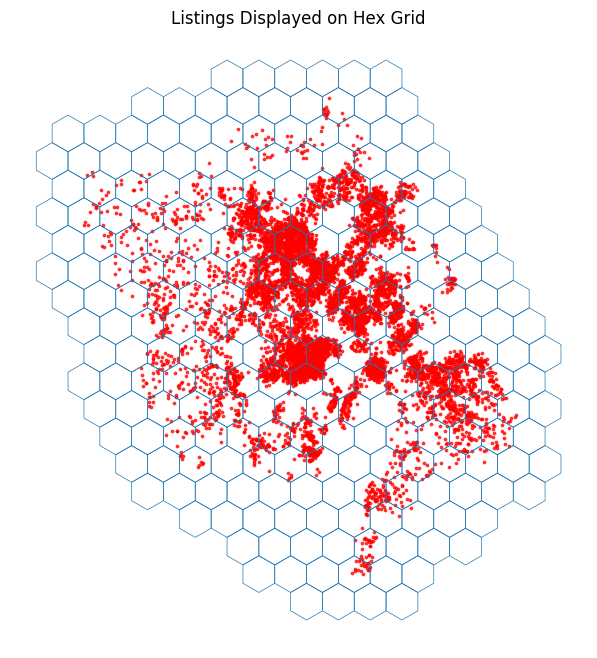

In [54]:
# --- Visualization: check that hexes look like hexes ---

fig, ax = plt.subplots(figsize=(8, 8))

# plot hex outlines
hex_grid.boundary.plot(ax=ax, linewidth=0.5)

# plot listing points
gdf.plot(ax=ax, markersize=3, color="red", alpha=0.7)

ax.set_title("Listings Displayed on Hex Grid")
ax.set_axis_off()
plt.show()

In [61]:
# Sanity check the hexbins by projecting them on map of Copenhagen

import folium

# Convert hexes and points to WGS84 (lat/lon)
hex_wgs = hex_grid.to_crs(epsg=4326)
pts_wgs = gdf.to_crs(epsg=4326)

center_lat = pts_wgs.geometry.y.mean()
center_lon = pts_wgs.geometry.x.mean()

m = folium.Map(location=[center_lat, center_lon],
               zoom_start=12.5)

folium.GeoJson(
    hex_wgs,
    name="Hex Grid Displayed on Map",
    style_function=lambda feature: {
        "fillColor": "none",
        "color": "blue",
        "weight": 1,
        "fillOpacity": 0.1,
    },
).add_to(m)

sample_pts = pts_wgs.sample(min(2000, len(pts_wgs)), random_state=0)

for _, row in pts_wgs.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=2,
        color="red",
        fill=True,
        fill_opacity=0.7,
    ).add_to(m)

m

In [ ]:
# Count unique hexes assigned to the dataset
print("Unique hex_id:",df["hex_id"].nunique())

# Check for missingness
print("Missing in hex_id:",df["hex_id"].isna().sum())

# Drop id, longitude and latitude since they are not needed anymore
df = df.drop(columns=["id", "longitude", "latitude"])

Unique hex_id: 143
Missing in hex_id: 0


## CLEAN UP "price" ATTRIBUTE



The "price" attribute is our target variable and as seen in the data audit, it is not a float. The following code parses the price to remove special characters and fix the data type.

In [ ]:
# Remove $, commas, and spaces, then convert to numeric
price_clean = (
    df["price"]
    .astype(str)                             # handle existing ints / NA
    .str.replace(r'[\$,]', '', regex=True)   # remove $ and commas
    .str.strip()
)

# Convert to numeric, coercing bad values (like '<NA>') to NaN
price_numeric = pd.to_numeric(price_clean, errors="coerce")

# Store back as nullable integer
df["price"] = price_numeric.astype("Int64")

## DROP NULLS FOR PRICE

Since "price" is our target variable, we have chosen to drop rows with null values. We cannot train our supervised models without a target variable, and imputing the target variable would be a major misstep, as it would introduce circular reasoning (training the model to predict its own best guess).

In [ ]:
display(df[["price"]].isna().sum().rename("null_count"))

price    2055
Name: null_count, dtype: int64

In [ ]:
# Drop null prices, as discussed above
df = df.dropna(subset=['price'])

In [ ]:
# Check df shape
print("Data set shape:",df.shape)

Data set shape: (7567, 40)


### VALIDATE PRICE ATTRIBUTE

In [ ]:
df["price"].describe()

count         7567.0
mean     1373.065812
std      1178.904303
min            202.0
25%            880.0
50%           1164.0
75%           1600.0
max          63418.0
Name: price, dtype: Float64

In [ ]:
top_10_prices = df.sort_values(by='price', ascending=False).head(10)
display(top_10_prices)

host_response_time  host_response_rate  host_acceptance_rate  \
8897      within an hour                99.0                 100.0   
6976      within an hour                99.0                  98.0   
2123      within an hour               100.0                 100.0   
7320      within an hour               100.0                 100.0   
6703      within an hour               100.0                 100.0   
7391      within an hour               100.0                  92.0   
1128      within an hour               100.0                 100.0   
9091  within a few hours               100.0                  98.0   
3562      within an hour               100.0                  96.0   
4338  within a few hours               100.0                  73.0   

      host_is_superhost  host_has_profile_pic  host_identity_verified  \
8897                  0                     1                       1   
6976                  0                     1                       1   
2123                  1                     1                       1   
7320                  1                     1                       1   
6703                  1                     1                       1   
7391                  1                     1                       1   
1128                  1                     1                       1   
9091                  0                     1                       1   
3562                  1                     1                       1   
4338                  0                     1                       1   

     neighbourhood_cleansed              property_type        room_type  \
8897          Frederiksberg         Entire rental unit  Entire home/apt   
6976                Nrrebro         Entire rental unit  Entire home/apt   
2123               Indre By  Entire serviced apartment  Entire home/apt   
7320               Indre By           Entire townhouse  Entire home/apt   
6703               Indre By         Entire rental unit  Entire home/apt   
7391               Indre By         Entire rental unit  Entire home/apt   
1128               Indre By  Entire serviced apartment  Entire home/apt   
9091               Indre By                       Boat  Entire home/apt   
3562                sterbro         Entire rental unit  Entire home/apt   
4338               Indre By         Entire rental unit  Entire home/apt   

      accommodates  bathrooms  bedrooms  beds  price  minimum_nights  \
8897             4        1.0       2.0   2.0  63418               1   
6976             4        1.0       2.0   2.0  40629               1   
2123             8        2.0       4.0   4.0  16643               3   
7320             6        1.0       3.0   5.0   9810               1   
6703            11        3.0       4.0   6.0   9643               1   
7391             6        2.0       3.0   3.0   9090               3   
1128             8        2.0       3.0   3.0   8840               1   
9091            16        4.0       9.0  16.0   8743               1   
3562             5        2.0       3.0   3.0   7977               3   
4338             4        2.0       1.0   2.0   7711               2   

      maximum_nights  number_of_reviews  instant_bookable  \
8897            1125                  3                 0   
6976            1125                 22                 1   
2123              60                 17                 0   
7320             365                 12                 1   
6703             365                 16                 1   
7391             365                  9                 0   
1128            1125                125                 0   
9091             365                  2                 0   
3562            1125                 27                 1   
4338             365                  8                 0   

      calculated_host_listings_count  description_missing  description_length  \
8897                             247                    0  

The above price statistics seem to be reasonable. For the high and low ends of the spectrum, we spot checked the listings on Airbnb.

## CORRECT DATA TYPES

The following code forces all included attributes into 1 of 4 data types to make subsequent pre-processing steps more streamlined.

In [ ]:
# -----------------------
# Define column groups
# -----------------------

# Columns that should be treated as categories
cat_cols = [
    "host_response_time",
    "neighbourhood_cleansed",
    "property_type",
    "room_type",
    "hex_id"
]

# Columns that should be treated as integers (no decimals)
int_cols = [
    "accommodates",
    "bedrooms",
    "beds",
    "minimum_nights",
    "maximum_nights",
    "number_of_reviews",
    "calculated_host_listings_count",
    "description_length",
    "host_about_length",
    "neighborhood_overview_length",
]

# Columns that should be treated as boolean
bool_cols = [
    "description_missing",
    "host_about_missing",
    "host_response_rate_missing",
    "host_acceptance_rate_missing",
    "neighborhood_overview_missing",
    "host_location_missing",
    "amenity_pool",
    "amenity_wifi",
    "amenity_parking",
    "amenity_ac",
    "amenity_kitchen",
    "amenity_hot_tub",
    "amenity_washer",
    "amenity_self_check_in",
    "amenity_tv",
    "amenity_grill",
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable",
]

# Columns that should be treated as floats (allowing decimals)
float_cols = [
    "host_response_rate",
    "host_acceptance_rate",
    "bathrooms",
    "host_tenure_days",
    "price",
]

# -------------------------------------------------
# Make sure beds / bedrooms are ints
# -------------------------------------------------

df["beds"] = df["beds"].round().astype("Int64")
df["bedrooms"] = df["bedrooms"].round().astype("Int64")

# -------------------------------------------------
# Build dtype_map
# -------------------------------------------------

dtype_map = {}

# categories
for c in cat_cols:
    dtype_map[c] = "category"

# boolean
for c in bool_cols:
    dtype_map[c] = "boolean"

# ints (nullable)
for c in int_cols:
    dtype_map[c] = "Int64"

# floats
for c in float_cols:
    dtype_map[c] = "float64"

# -----------------------------------
# Apply all conversions at once
# -----------------------------------

df = df.astype(dtype_map)


## RE-AUDIT THE DATA AFTER CLEANSING

In [ ]:
# Run the function to show the various metrics defined

audit_dataframe(df, name="Airbnb Data")


=== AIRBNB DATA AUDIT: Airbnb Data ===

Shape: 7567 rows × 40 columns

---- Missing Values ----


null_count  null_percent    dtype
host_response_rate           340          4.49  float64
host_acceptance_rate          85          1.12  float64



---- Data Types ----


dtype
host_response_time              category
host_response_rate               float64
host_acceptance_rate             float64
host_is_superhost                boolean
host_has_profile_pic             boolean
host_identity_verified           boolean
neighbourhood_cleansed          category
property_type                   category
room_type                       category
accommodates                       Int64
bathrooms                        float64
bedrooms                           Int64
beds                               Int64
price                            float64
minimum_nights                     Int64
maximum_nights                     Int64
number_of_reviews                  Int64
instant_bookable                 boolean
calculated_host_listings_count     Int64
description_missing              boolean
description_length                 Int64
host_tenure_days                 float64
host_about_missing               boolean
host_about_length                  Int64
host_response_rate_missing       boolean
host_acceptance_rate_missing     boolean
neighborhood_overview_missing    boolean
neighborhood_overview_length       Int64
host_location_missing            boolean
amenity_pool                     boolean
amenity_wifi                     boolean
amenity_parking                  boolean
amenity_ac                       boolean
amenity_kitchen                  boolean
amenity_hot_tub                  boolean
amenity_washer                   boolean
amenity_self_check_in            boolean
amenity_tv                       boolean
amenity_grill                    boolean
hex_id                          category



---- Descriptive Statistics (Numerical) ----


count         mean          std    min  \
host_response_rate              7227.0    91.759651    19.393751    0.0   
host_acceptance_rate            7482.0    71.369019    27.229198    0.0   
accommodates                    7567.0     3.342804     1.741592    1.0   
bathrooms                       7567.0     1.078961     0.311484    0.0   
bedrooms                        7567.0     1.537069     0.865022    0.0   
beds                            7567.0     1.818951     1.256438    0.0   
price                           7567.0  1373.065812  1178.904303  202.0   
minimum_nights                  7567.0     3.231664     5.939991    1.0   
maximum_nights                  7567.0   285.521739   346.933307    1.0   
number_of_reviews               7567.0    32.197172    71.340547    1.0   
calculated_host_listings_count  7567.0     4.556363    23.684048    1.0   
description_length              7567.0   400.135853    146.05428    0.0   
host_tenure_days                7567.0  2913.816836  1330.090469   13.0   
host_about_length               7567.0   106.943835   183.811382    0.0   
neighborhood_overview_length    7567.0   138.290736   261.119207    0.0   

                                   25%     50%     75%      max  
host_response_rate                96.0   100.0   100.0    100.0  
host_acceptance_rate              50.0    78.0    99.0    100.0  
accommodates                       2.0     3.0     4.0     16.0  
bathrooms                          1.0     1.0     1.0      5.0  
bedrooms                           1.0     1.0     2.0      9.0  
beds                               1.0     1.0     2.0     16.0  
price                            880.0  1164.0  1600.0  63418.0  
minimum_nights                     2.0     3.0     4.0    365.0  
maximum_nights                    20.0   100.0   365.0   1125.0  
number_of_reviews                  5.0    12.0    32.0   2366.0  
calculated_host_listings_count     1.0     1.0     1.0    247.0  
description_length               311.0   457.0   508.0   1000.0  
host_tenure_days                2072.5  3258.0  3922.5   5880.0  
host_about_length                  0.0     0.0   161.0   2177.0  
neighborhood_overview_length       0.0     0.0   175.0   1000.0



---- Descriptive Statistics (Categorical) ----


count unique                 top  freq
host_response_time      7567      5      within an hour  3000
neighbourhood_cleansed  7567     11            Indre By  1383
property_type           7567     44  Entire rental unit  4393
room_type               7567      4     Entire home/apt  6855
hex_id                  7567    143                 166   388



---- Unique Value Counts ----


unique_counts
host_is_superhost                           2
host_has_profile_pic                        2
host_identity_verified                      2
host_location_missing                       2
amenity_wifi                                2
host_about_missing                          2
amenity_pool                                2
amenity_parking                             2
host_response_rate_missing                  2
host_acceptance_rate_missing                2
neighborhood_overview_missing               2
instant_bookable                            2
description_missing                         2
amenity_hot_tub                             2
amenity_kitchen                             2
amenity_ac                                  2
amenity_washer                              2
amenity_grill                               2
amenity_tv                                  2
amenity_self_check_in                       2
room_type                                   4
host_response_time                          5
bedrooms                                    9
bathrooms                                  10
neighbourhood_cleansed                     11
accommodates                               15
beds                                       15
calculated_host_listings_count             23
minimum_nights                             33
property_type                              44
host_response_rate                         84
host_acceptance_rate                      100
maximum_nights                            137
hex_id                                    143
number_of_reviews                         319
host_about_length                         570
description_length                        590
neighborhood_overview_length              739
price                                    2016
host_tenure_days                         3332



---- Boolean Column Distributions ----


column    dtype  true_count  false_count  na_count  \
0               host_is_superhost  boolean        1683         5884         0   
1            host_has_profile_pic  boolean        7331          236         0   
2          host_identity_verified  boolean        6892          675         0   
3                instant_bookable  boolean         866         6701         0   
4             description_missing  boolean         134         7433         0   
5              host_about_missing  boolean        4341         3226         0   
6      host_response_rate_missing  boolean         340         7227         0   
7    host_acceptance_rate_missing  boolean          85         7482         0   
8   neighborhood_overview_missing  boolean        4943         2624         0   
9           host_location_missing  boolean        1302         6265         0   
10                   amenity_pool  boolean          55         7512         0   
11                   amenity_wifi  boolean        7399          168         0   
12                amenity_parking  boolean         918         6649         0   
13                     amenity_ac  boolean         204         7363         0   
14                amenity_kitchen  boolean        7326          241         0   
15                amenity_hot_tub  boolean          41         7526         0   
16                 amenity_washer  boolean        6834          733         0   
17          amenity_self_check_in  boolean        3004         4563         0   
18                     amenity_tv  boolean        5786         1781         0   
19                  amenity_grill  boolean        1670         5897         0   

    true_percent  false_percent  na_percent  
0          22.24          77.76         0.0  
1          96.88           3.12         0.0  
2          91.08           8.92         0.0  
3          11.44          88.56         0.0  
4           1.77          98.23         0.0  
5          57.37          42.63         0.0  
6           4.49          95.51         0.0  
7           1.12          98.88         0.0  
8          65.32          34.68         0.0  
9          17.21          82.79         0.0  
10          0.73          99.27         0.0  
11         97.78           2.22         0.0  
12         12.13          87.87         0.0  
13          2.70          97.30         0.0  
14         96.82           3.18         0.0  
15          0.54          99.46         0.0  
16         90.31           9.69         0.0  
17         39.70          60.30         0.0  
18         76.46          23.54         0.0  
19         22.07          77.93         0.0



---- Categorical Cardinality ----


column  unique_values
0      host_response_time              5
1  neighbourhood_cleansed             11
2           property_type             44
3               room_type              4
4                  hex_id            143



---- Duplicate Rows ----


duplicate_rows
0               0



---- Sample Values ----


host_response_time  host_response_rate  host_acceptance_rate  \
287       within an hour               100.0                  20.0   
7084      within an hour               100.0                 100.0   
7628        within a day               100.0                  42.0   
7754      within an hour               100.0                  93.0   
4278  within a few hours               100.0                  81.0   

      host_is_superhost  host_has_profile_pic  host_identity_verified  \
287               False                  True                    True   
7084              False                  True                   False   
7628              False                  True                    True   
7754              False                  True                    True   
4278               True                  True                    True   

     neighbourhood_cleansed         property_type        room_type  \
287                 Nrrebro          Entire condo  Entire home/apt   
7084               Indre By    Entire rental unit  Entire home/apt   
7628               Indre By    Entire rental unit  Entire home/apt   
7754              Amager st  Private room in home     Private room   
4278                Nrrebro          Entire condo  Entire home/apt   

      accommodates  bathrooms  bedrooms  beds   price  minimum_nights  \
287              2        1.5         1     1  1464.0               4   
7084             2        1.0         1     1  1700.0               2   
7628             2        1.0         1     2  1378.0               4   
7754             2        0.5         1     1   400.0               1   
4278             2        1.0         2     1   990.0               3   

      maximum_nights  number_of_reviews  instant_bookable  \
287              700                 36             False   
7084             365                  3             False   
7628            1125                 13             False   
7754             365                 43             False   
4278               6                 16             False   

      calculated_host_listings_count  description_missing  description_length  \
287                                1                False                 394   
7084                               1                False                 358   
7628                               1                 True                   0   
7754                               1                False                 409   
4278                               1                False                 404   

      host_tenure_days  host_about_missing  host_about_length  \
287             4115.0                True                  0   
7084            2645.0                True                  0   
7628            2303.0                True                  0   
7754             310.0                True                  0   
4278            5068.0               False                159   

      host_response_rate_missing  host_acceptance_rate_missing  \
287                        False                         False   
7084                       False                         False   
7628                       False                         False   
7754                       False                         False   
4278                       False                         False   

      neighborhood_overview_missing  neighborhood_overview_length  \
287                           False                           652   
7084                           True                             0   
7628                           True                             0   
7754                           True                             0   
4278                           True                             0   

      host_location_missing  amenity_pool  amenity_wifi  amenity_parking  \
287                   False         False          True            False   
7084                  False         False          True            False   
7



=== END AUDIT ===



As discussed above, the null values for host_response_rate and host_acceptance_rate will be handled in the pipeline. Everything else looks good.

# IMPORT LIBRARIES FOR MODELING

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, max_error, mean_absolute_percentage_error)

# TRAIN/TEST SPLIT AND PREPROCESSING

The following code establishes the target variable as "price" and performs an initial training/test split of 80%/20%.

It then sets up the preprocessor to transform the columns: it will impute the median for missing values (only host_acceptance_rate and host_response_rate),scale the numeric values, pass through the boolean values, and onehot encode the categorical values. This preprocessor will eventually be passed to a pipeline so that we apply the necessary preprocessing consistently, and don't need to keep track of which columns are in which group.

In [ ]:
# ======================================
# DEFINE TARGET (y) AND FEATURES (X)
# ======================================

target_col = "price"

# X = all columns except the target
X = df.drop(columns=[target_col])

# y = the target column
y = df[target_col]


# ===============================================
# TRAIN / TEST SPLIT (BEFORE ANY PREPROCESSING)
# ===============================================

# We split the data into:
# - Training set (used to fit/learn the model - we will perform cross validation within the training set)
# - Test set (a hold-out to evaluate final performance)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# ============================================
# IDENTIFY NUMERIC, BOOLEAN, AND CATEGORICAL FEATURES
# ============================================

boolean_features = X_train.select_dtypes(include="boolean").columns.tolist()
numeric_features = (
    X_train
    .select_dtypes(include=["float64", "Int64"])
    .columns
    .difference(boolean_features)
    .tolist()
)
categorical_features = X_train.select_dtypes(include=["category"]).columns.tolist()

print("Boolean features:", boolean_features)
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# ===================================================
# SET UP PREPROCESSING STEPS
# ===================================================

# - Numeric features: SimpleImputer, StandardScaler
# - Boolean features: "passthrough" (keep 0/1 as-is)
# - Categorical features: OneHotEncoder

# This "preprocessor" will later be plugged into a Pipeline
# together with a model (e.g., Ridge, RandomForest, KNN).

numeric_transformer = Pipeline(steps=[
    # 1. Impute: Fills NaNs using the median calculated on the training data
          # THIS IS RELEVANT ONLY FOR "host_acceptance_rate" and "host_response_rate" attributes
    ('imputer', SimpleImputer(strategy='median')),
    # 2. Scale: Standardize features
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        # ("name_for_step", transformer_object, list_of_columns)
        ("num", numeric_transformer, numeric_features),
        ("bool", "passthrough", boolean_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

print("\nPreprocessing setup complete.\n")
print(f"  Numeric features: {len(numeric_features)}")
print(f"  Boolean features: {len(boolean_features)}")
print(f"  Categorical features: {len(categorical_features)}")

Boolean features: ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'description_missing', 'host_about_missing', 'host_response_rate_missing', 'host_acceptance_rate_missing', 'neighborhood_overview_missing', 'host_location_missing', 'amenity_pool', 'amenity_wifi', 'amenity_parking', 'amenity_ac', 'amenity_kitchen', 'amenity_hot_tub', 'amenity_washer', 'amenity_self_check_in', 'amenity_tv', 'amenity_grill']
Numeric features: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'calculated_host_listings_count', 'description_length', 'host_about_length', 'host_acceptance_rate', 'host_response_rate', 'host_tenure_days', 'maximum_nights', 'minimum_nights', 'neighborhood_overview_length', 'number_of_reviews']
Categorical features: ['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type', 'hex_id']

Preprocessing setup complete.

  Numeric features: 14
  Boolean features: 20
  Categorical features: 5


There is a total of 39 columns, since the target variable (price) has been excluded from the training set

# ESTABLISH BASELINES

The code below creates a function that defines scoring metrics so we can train a handful of baseline models. We will be looking at Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R².

The baseline models allow us to determine which ones are worth pursuing in the GridSearchCV step for hyperparameter tuning.

In [ ]:
from sklearn.dummy import DummyRegressor

# The following function wraps the given model in a pipeline with the
# preprocessor and evaluates it with cross-validation on the training
# data. No test-set evaluation happens here to prevents leakage.

def evaluate_model(model, model_name):

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model),
    ])

   # --- CV MAE ---
    cv_mae_scores = -cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring="neg_mean_absolute_error"
    )
    cv_mae_mean = cv_mae_scores.mean()

    # --- CV RMSE ---
    cv_rmse_scores = np.sqrt(
        -cross_val_score(
            pipe,
            X_train,
            y_train,
            cv=5,
            scoring="neg_mean_squared_error"
        )
    )
    cv_rmse_mean = cv_rmse_scores.mean()

    # --- CV R² ---
    cv_r2_scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring="r2"
    )
    cv_r2_mean = cv_r2_scores.mean()

    print(f"\n=== {model_name} (CV Only) ===")
    print(f"CV MAE:  {cv_mae_mean:.3f}")
    print(f"CV RMSE: {cv_rmse_mean:.3f}")
    print(f"CV R²:   {cv_r2_mean:.3f}")

    return {
        "model": model_name,
        "cv_mae": cv_mae_mean,
        "cv_rmse": cv_rmse_mean,
        "cv_r2": cv_r2_mean,
    }

In [ ]:
# 1) Baseline: predict the mean availability
baseline_results = evaluate_model(
    DummyRegressor(strategy="mean"),
    "DummyRegressor (mean)"
)


=== DummyRegressor (mean) (CV Only) ===
CV MAE:  561.777
CV RMSE: 1171.489
CV R²:   -0.001


These results tell us that if we always predict the mean price for a new listing, the average error (MAE) will be 561.777 DKK (in either direction). The RSME is higher (1171.489 DKK) because the model makes some larger errors, which are punished more aggresively. The R² of 0 makes sense, since the model explains none of the variance in the data.

In [ ]:
# 2) Simple Linear Regression
linreg_results = evaluate_model(
    LinearRegression(),
    "LinearRegression"
)


=== LinearRegression (CV Only) ===
CV MAE:  392.501
CV RMSE: 987.968
CV R²:   0.336


This simple regression model improved the MAE (that is, how many DKK on average the model is off by) to 392.501 DKK. The RMSE is slightly better at 987.968 DKK. The R² value is 0.336, meaning that this model captures 33.6% of the variance in the data.

In [ ]:
# 3) Decision Tree (nonlinear, baseline settings)
dt_results = evaluate_model(
    DecisionTreeRegressor(random_state=42),
    "DecisionTreeRegressor"
)


=== DecisionTreeRegressor (CV Only) ===
CV MAE:  499.928
CV RMSE: 1346.012
CV R²:   -0.938


The decision tree is worse by all metrics than simple linear regression. The R² value is negative, meaning the model is worse at predicting the price than simply guessing the average. The MAE is 499.928 DKK and the RMSE is 1346.012 DKK.

**THIS MODEL IS NOT WORTH PURSUING AND WILL THUS BE EXCLUDED FROM GRIDSEARCHCV**

In [ ]:
# 4) Random Forest (nonlinear ensemble)
rf_results = evaluate_model(
    RandomForestRegressor(
        n_estimators=30,
        random_state=42
    ),
    "RandomForestRegressor"
)


=== RandomForestRegressor (CV Only) ===
CV MAE:  368.995
CV RMSE: 1067.613
CV R²:   0.117


The random forest improves the MAE but has a lower R² value, meaning it explains less of the variance in the price than the linear regression estimator and is theoretically a worse fit.

MAE:  368.995;
RMSE: 1067.613;
R²:   0.117

In [ ]:
# 5) Gradient Boosting (strong nonlinear model)
gbr_results = evaluate_model(
    GradientBoostingRegressor(
        random_state=42,
        learning_rate=0.1,
        n_estimators=30
    ),
    "GradientBoostingRegressor"
)


=== GradientBoostingRegressor (CV Only) ===
CV MAE:  383.271
CV RMSE: 1027.265
CV R²:   0.259


MAE:  383.271;
RMSE: 1027.265;
R²:   0.259

In [ ]:
# 6) KNN (instance-based model)
knn_results = evaluate_model(
    KNeighborsRegressor(n_neighbors=5),
    "KNeighborsRegressor (k=5)"
)


=== KNeighborsRegressor (k=5) (CV Only) ===
CV MAE:  413.465
CV RMSE: 1072.898
CV R²:   0.186


MAE:  413.465;
RMSE: 1072.898;
R²:   0.186

# DEFINE THE MODELS AND ASSOCIATED HYPERPARAMETERS SO WE CAN FIND THE BEST COMBINATION USING GRIDSEARCHCV

In [ ]:
# ==========================================
# DEFINE MODELS AND THEIR PARAMETER GRIDS BASED ON PRELIMINARY RESULTS ABOVE
# ==========================================

# We create a dictionary where:
# - The key (e.g., "ridge") is the name we choose for the model
# - The value holds:
#     - "estimator": the actual sklearn model object
#     - "param_grid": a dictionary of hyperparameters to explore for that model

# IMPORTANT:
# When we plug a model into a Pipeline with the step name "model",
# we must prefix hyperparameter names with "model__" so GridSearchCV
# knows which step in the pipeline they belong to.

models_config = {
    "linear_regression": {
        "estimator": LinearRegression(),
        "param_grid": {} # No hyperparameters for linear regression
    },
    "ridge": {
        "estimator": Ridge(random_state=42),   # Ridge regression (L2 regularization)
        "param_grid": {
            # alpha controls the strength of regularization:
            # - small alpha: weak regularization (closer to plain linear regression)
            # - large alpha: stronger shrinkage of coefficients
            "model__alpha": [0.1, 1.0, 10.0]
        }
    },
    "lasso": {
        "estimator": Lasso(random_state=42),   # Lasso regression (L1 regularization)
        "param_grid": {
            # L1 can drive some coefficients exactly to zero (feature selection)
            "model__alpha": [0.01, 0.1, 1.0]
        }
    },
    "random_forest": {
        "estimator": RandomForestRegressor(random_state=42),
        "param_grid": {
            # n_estimators: number of trees in the forest
            "model__n_estimators": [100, 200],
            # max_depth: how deep each individual tree can grow (controls overfitting)
            "model__max_depth": [5, 10, 20],
            # min_samples_leaf: minimum samples in a leaf node (controls overfitting)
            "model__min_samples_leaf": [5, 10, 20]
        }
    },
    "GradientBoosting": {   # Similar to random_forest, but sequentially addresses error, rather than averaging
        "estimator": GradientBoostingRegressor(random_state=42),
        "param_grid": {
            "model__n_estimators": [100, 200, 300],
            "model__learning_rate": [0.01, 0.1]
        }
  },
    "knn": {
        "estimator": KNeighborsRegressor(),
        "param_grid": {
            "model__n_neighbors": [3, 7, 11, 15, 20],
            "model__weights": ["uniform", "distance"],
            "model__metric": ["euclidean", "manhattan"]
        }
  }
}

# LOOP OVER EACH MODEL IN THE CONFIG DICTIONARY ABOVE AND RUN GRIDSEARCHCV TO ESTABLISH THE BEST COMBINATION OF HYPERPARAMETERS

In [ ]:
# ============================================
# LOOP OVER MODELS: BUILD PIPELINE + TUNE IT
# ============================================

results = []          # store a summary of results for each model in this list
best_estimators = {}  # store the refit best pipeline per model

# We use the same primary evaluation metric for all models:
# - MAE (Mean Absolute Error) as scoring metric in CV
#   (in sklearn, higher scores are better, so we use "neg_mean_absolute_error")
cv_scoring_metrics = {
    "MAE": "neg_mean_absolute_error",
    "RMSE": "neg_mean_squared_error",
    "R2": "r2",
}
primary_scoring_metric = cv_scoring_metrics["MAE"]

for name, cfg in models_config.items():
    print(f"\n======================")
    print(f"Running GridSearch for: {name}")
    print(f"======================")

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", cfg["estimator"])
    ])

    # GridSearchCV will:
    # - try all combinations of hyperparameters in cfg["param_grid"]
    # - for each combination, perform cross-validation (cv=5 splits)
    # - use the scoring metric (negative MAE) to rank combinations
    # - keep track of the best combination found

    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=cfg["param_grid"],
        cv=5,                                            # uses 5-fold cross-validation
        scoring=primary_scoring_metric,                          # "neg_mean_absolute_error"
        verbose=1                                        # print progress
    )

    grid_search.fit(X_train, y_train)                    # runs gridsearch to test all combinations of hyperparameters

    print("Best hyperparameters found (CV):")
    print(grid_search.best_params_)

    best_estimator = grid_search.best_estimator_

    # Get the primary metric (MAE)
    best_cv_mae = -grid_search.best_score_
    print(f"Best CV MAE: {best_cv_mae:.3f}")

    # Use cross_val_score to calculate secondary metrics (RMSE and R2)
    cv_r2_scores = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring=cv_scoring_metrics["R2"])
    cv_rmse_scores = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring=cv_scoring_metrics["RMSE"])

    # Calculate the means of the cross-validation folds
    mean_cv_r2 = cv_r2_scores.mean()

    # RMSE is the negative square root of the negative Mean Squared Error
    mean_cv_rmse = np.sqrt(-cv_rmse_scores.mean())

    print(f"Best CV RMSE: {mean_cv_rmse:.3f}")
    print(f"Best CV R²: {mean_cv_r2:.3f}")

    # Store all metrics
    results.append({
        "Model": name,
        "Best CV MAE": best_cv_mae,
        "Best CV RMSE": mean_cv_rmse,
        "Best CV R²": mean_cv_r2,
        "Best Hyperparams": grid_search.best_params_,
    })

    best_estimators[name] = best_estimator

# Create the final results DataFrame
final_cv_results_df = pd.DataFrame(results)

# Clean up column names and index
final_cv_results_df.set_index("Model", inplace=True)
final_cv_results_df.sort_values(by="Best CV MAE", inplace=True)

print("\n\n===== FINAL CROSS-VALIDATION RESULTS (Sorted by Best CV MAE) =====")
display(final_cv_results_df)


Running GridSearch for: linear_regression
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters found (CV):
{}
Best CV MAE: 392.501
Best CV RMSE: 1103.504
Best CV R²: 0.336

Running GridSearch for: ridge
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best hyperparameters found (CV):
{'model__alpha': 10.0}
Best CV MAE: 381.227
Best CV RMSE: 1096.788
Best CV R²: 0.353

Running GridSearch for: lasso
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238192472.37651157, tolerance: 840168.8075004747
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135118695.89338398, tolerance: 488573.82579737704
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106439587.35893059, tolerance: 871829.0532080344
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: Conv

Best hyperparameters found (CV):
{'model__alpha': 1.0}
Best CV MAE: 382.177
Best CV RMSE: 1098.243
Best CV R²: 0.352

Running GridSearch for: random_forest
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best hyperparameters found (CV):
{'model__max_depth': 20, 'model__min_samples_leaf': 5, 'model__n_estimators': 200}
Best CV MAE: 366.238
Best CV RMSE: 1100.909
Best CV R²: 0.344

Running GridSearch for: GradientBoosting
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparameters found (CV):
{'model__learning_rate': 0.1, 'model__n_estimators': 300}
Best CV MAE: 359.558
Best CV RMSE: 1115.972
Best CV R²: 0.292

Running GridSearch for: knn
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters found (CV):
{'model__metric': 'manhattan', 'model__n_neighbors': 15, 'model__weights': 'distance'}
Best CV MAE: 383.970
Best CV RMSE: 1123.071
Best CV R²: 0.292


===== FINAL CROSS-VALIDATION RESULTS (Sorted by Best CV MAE) =====


Best CV MAE  Best CV RMSE  Best CV R²  \
Model                                                      
GradientBoosting    359.557896   1115.971718    0.292118   
random_forest       366.238265   1100.909205    0.343585   
ridge               381.227334   1096.788400    0.353229   
lasso               382.176593   1098.242627    0.351504   
knn                 383.969567   1123.070546    0.292268   
linear_regression   392.500656   1103.503763    0.336102   

                                                    Best Hyperparams  
Model                                                                 
GradientBoosting   {'model__learning_rate': 0.1, 'model__n_estima...  
random_forest      {'model__max_depth': 20, 'model__min_samples_l...  
ridge                                         {'model__alpha': 10.0}  
lasso                                          {'model__alpha': 1.0}  
knn                {'model__metric': 'manhattan', 'model__n_neigh...  
linear_regression                                                 {}

ANALYZE RESULTS WHEN DONE

# TEST HOMOSKEDASTICITY [THE RESULTS SEEM WRONG, DOUBLE CHECK LOGIC]

Generating Homoscedasticity Residuals Plots for ALL Models (Training Data)...
All residuals plots generated and displayed (Training Data).


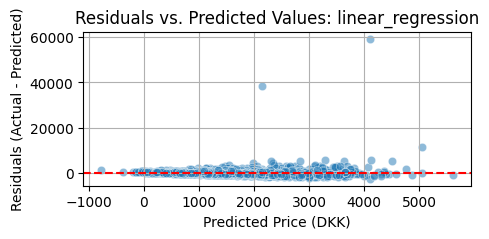

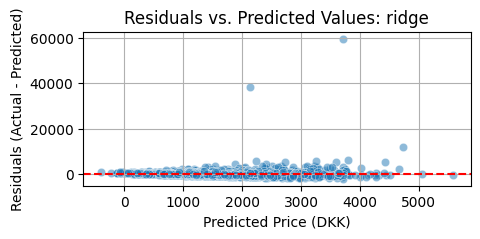

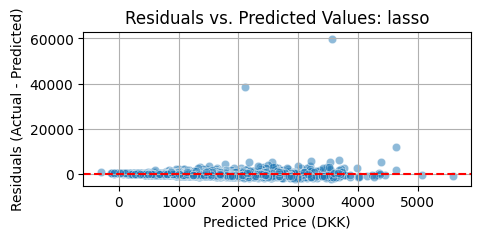

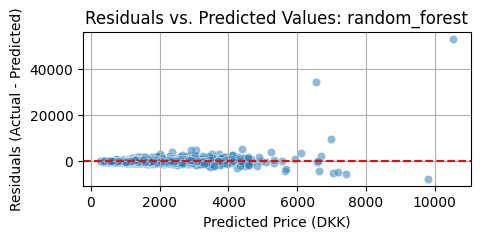

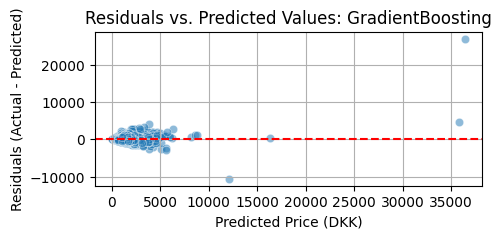

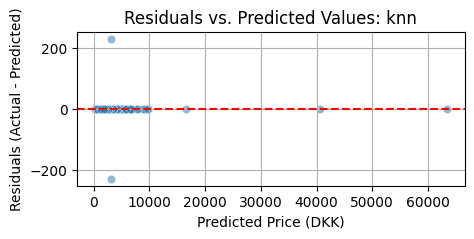

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# =================================================================
# HOMOSCEDASTICITY CHECK (VISUAL) FOR ALL MODELS ON TRAINING DATA
# =================================================================

print("Generating Homoscedasticity Residuals Plots for ALL Models (Training Data)...")

# Loop through all models whose best configuration was found and refit
for model_name, final_model in best_estimators.items():

    # 1. Generate predictions on the Training Data
    y_pred_train = final_model.predict(X_train)

    # 2. Calculate Residuals
    residuals_train = y_train - y_pred_train

    # 3. Create the Residuals Plot
    plt.figure(figsize=(5, 2))
    sns.scatterplot(x=y_pred_train, y=residuals_train, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--') # Add the zero line for reference
    plt.title(f'Residuals vs. Predicted Values: {model_name}')
    plt.xlabel('Predicted Price (DKK)')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.grid(True)

    # Save and display the plot
    plt.savefig(f'{model_name}_homoscedasticity_check.png')
    # The plot will display automatically here.

print("All residuals plots generated and displayed (Training Data).")

# RANK THE MODELS BASED ON CV RESULTS AND CHOOSE THE BEST MODEL FOR FINAL TEST SET ANALYSIS

In [ ]:
# =======================================
# CREATE SUMMARY TABLE OF MODEL RESULTS
# =======================================

# Convert the list of result dicts into a DataFrame.
# Each row corresponds to one model (linear regression, ridge, lasso, RF, GB)
results_df = pd.DataFrame(results)

# Sort models by their CV MAE (lower is better performance).
# We reset the index so the top model becomes row 0.
results_df = (
    results_df
    .sort_values(by="Best CV MAE", ascending=True)
    .reset_index(drop=True)
)

print("\n===== MODEL COMPARISON (by CV MAE — lower is better) =====")
display(results_df)


===== MODEL COMPARISON (by CV MAE — lower is better) =====


Model  Best CV MAE  Best CV RMSE  Best CV R²  \
0   GradientBoosting   359.557896   1115.971718    0.292118   
1      random_forest   366.238265   1100.909205    0.343585   
2              ridge   381.227334   1096.788400    0.353229   
3              lasso   382.176593   1098.242627    0.351504   
4                knn   383.969567   1123.070546    0.292268   
5  linear_regression   392.500656   1103.503763    0.336102   

                                    Best Hyperparams  
0  {'model__learning_rate': 0.1, 'model__n_estima...  
1  {'model__max_depth': 20, 'model__min_samples_l...  
2                             {'model__alpha': 10.0}  
3                              {'model__alpha': 1.0}  
4  {'model__metric': 'manhattan', 'model__n_neigh...  
5                                                 {}

In [ ]:
# =================================================================
# EVALUATE ALL MODELS ON THE HELD-OUT TEST SET
# =================================================================

test_results_list = []

print("\n\n=============================================")
print("EVALUATING ALL MODELS ON HELD-OUT TEST SET")
print("=============================================")

# Loop through every model whose best configuration was found and refit
for model_name, final_model in best_estimators.items():

    # Generate predictions for the held-out test set
    y_pred_test = final_model.predict(X_test)

    # Compute evaluation metrics
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)

    # Store the results
    test_results_list.append({
        "Model": model_name,
        "Test MAE":  test_mae,
        "Test RMSE": test_rmse,
        "Test R²":   test_r2,
    })

# Create the final results DataFrame
all_test_results_df = pd.DataFrame(test_results_list)
all_test_results_df.set_index("Model", inplace=True)

# Sort by MAE to easily see the best performer on the test set
all_test_results_df.sort_values(by="Test MAE", inplace=True)

print("\n===== ALL MODELS: FINAL TEST PERFORMANCE (held-out) =====")
display(all_test_results_df)



EVALUATING ALL MODELS ON HELD-OUT TEST SET

===== ALL MODELS: FINAL TEST PERFORMANCE (held-out) =====


Test MAE   Test RMSE   Test R²
Model                                              
random_forest      345.226849  524.622222  0.614528
GradientBoosting   348.290369  541.786579  0.588892
knn                374.835888  601.659324  0.493008
ridge              377.046145  554.535965  0.569316
lasso              378.070903  559.851243  0.561020
linear_regression  385.700442  563.728280  0.554919